In [8]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [9]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [10]:
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

7.6%

100.0%


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


100.0%
45.7%


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100.0%
100.0%


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [11]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [13]:
#загружаем не всю выборку а только часть(128 изображений)
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [14]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [15]:
features = 784
classes = 10

In [16]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[ 0.0061, -0.0227,  0.0259,  ..., -0.0272, -0.0240,  0.0140],
        [ 0.0152,  0.0244, -0.0097,  ...,  0.0279, -0.0194,  0.0324],
        [ 0.0019,  0.0326, -0.0214,  ..., -0.0138,  0.0228,  0.0104],
        ...,
        [-0.0059,  0.0018,  0.0136,  ..., -0.0242,  0.0113,  0.0019],
        [-0.0259,  0.0349,  0.0336,  ..., -0.0139,  0.0152,  0.0013],
        [ 0.0248,  0.0149, -0.0111,  ...,  0.0038,  0.0014, -0.0128]],
       requires_grad=True)

In [17]:
epochs = 3
lr=1e-2
history = []

In [18]:
import numpy as np
from torch.nn.functional import cross_entropy

In [19]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:
    
        # загружаем батч данных (вытянутый в линию)
        x_batch = x_batch.reshape(x_batch.shape[0], -1)

        # вычисляем функцию потерь (log loss, также известная как кросс-энтропия)
        logits = x_batch @ W
        probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)
    
        loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
        history.append(loss.item())

        # вычисляем градиенты
        loss.backward()

        # делаем шаг градиентного спуска
        grad = W.grad
        with torch.no_grad():
            W -= lr * grad
        W.grad.zero_()

    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.1992710828781128
2,	 loss: 0.14228956401348114
3,	 loss: 0.12131427973508835


In [20]:
import matplotlib.pyplot as plt

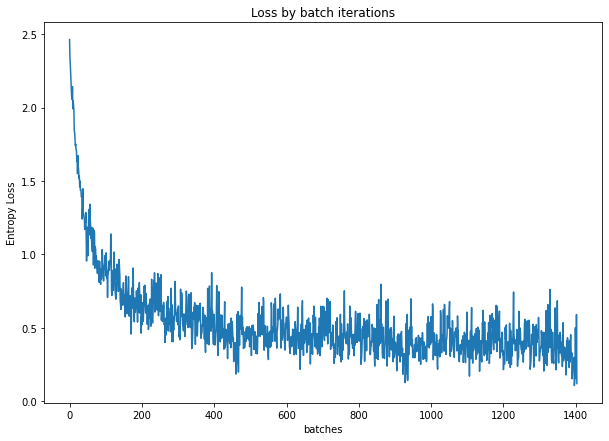

In [21]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [22]:
from sklearn.metrics import accuracy_score

In [24]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    # загружаем батч данных (вытянутый в линию)
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch

    preds = torch.argmax(x_batch @ W, dim=1)
    acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.899


## Другой способ построения модели нейронной сети

In [27]:
import torch.nn as nn
from torchsummary import summary

In [29]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes)
)

In [31]:
summary(model, (features,), batch_size=228) #вывод данных о структуре сети

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [228, 64]          50,240
              ReLU-2                  [228, 64]               0
            Linear-3                  [228, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 0.24
Params size (MB): 0.19
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


In [32]:
criterion = nn.CrossEntropyLoss()      

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [37]:
epochs = 10
history = []

In [38]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:
        # 1. # загружаем батч данных (вытянутый в линию)
        x_batch = x_batch.view(x_batch.shape[0], -1)

        # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
        logits = model(x_batch)

        # 3. вычислеяем - функцию потерь (loss)
        loss = criterion(logits, y_batch)
        history.append(loss.item())

        # 4. вычисляем градиенты
        optimizer.zero_grad()
        loss.backward()

        # 5. шаг градиентного спуска
        optimizer.step()

    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.05739976093173027
2,	 loss: 0.05246352404356003
3,	 loss: 0.04892631992697716
4,	 loss: 0.038396235555410385
5,	 loss: 0.030058281496167183
6,	 loss: 0.026590073481202126
7,	 loss: 0.021310247480869293
8,	 loss: 0.018622389063239098
9,	 loss: 0.014594942331314087
10,	 loss: 0.013288597576320171


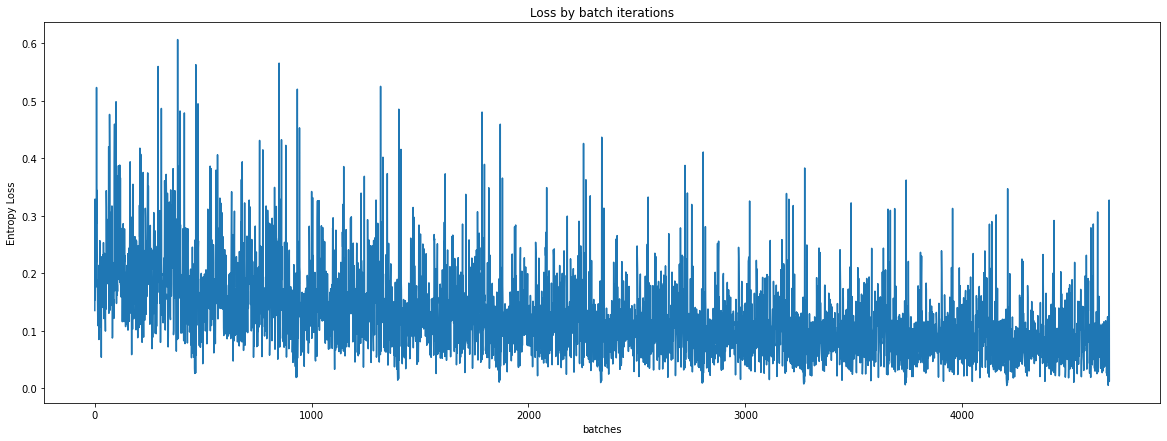

In [40]:
plt.figure(figsize=(20, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [41]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    # загружаем батч данных (вытянутый в линию)
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1)

    preds = torch.argmax(model(x_batch), dim=1)
    acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.96
